In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib # For path manipulation

# For evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Ensure TensorFlow can see your GPU (if you have one)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import tensorflow as tf

print(f"TensorFlow version (should be tensorflow-macos): {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    print("TensorFlow is using the GPU (Metal).")
    for gpu in gpus:
        print(f"  - Name: {gpu.name}, Type: {gpu.device_type}")
else:
    print("TensorFlow is NOT using the GPU. Check your tensorflow-metal installation and compatibility.")
    print("Ensure you are running on an Apple Silicon Mac.")
    print("Verify tensorflow-macos and tensorflow-metal versions from Apple's official documentation.")

TensorFlow version (should be tensorflow-macos): 2.15.0
Num GPUs Available: 1
TensorFlow is using the GPU (Metal).
  - Name: /physical_device:GPU:0, Type: GPU


In [7]:
# Define paths
dataset_dir = pathlib.Path('dataset/') # Change this to your dataset path
train_dir = dataset_dir / 'train'
val_dir = dataset_dir / 'valid'
test_dir = dataset_dir / 'test'

# Image and batch parameters
IMG_HEIGHT = 224 # Standard for many pre-trained models like EfficientNet, MobileNet
IMG_WIDTH = 224
BATCH_SIZE = 32 # Adjust based on your GPU memory


In [ ]:

# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',        # Infer labels from directory names
    label_mode='categorical', # For categorical_crossentropy loss
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',  # Or 'bilinear'
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

# Load test data
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle test data
)

# Get class names (important for later interpretation)
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize pixel values (0-255 to 0-1)
# This can be done with a Rescaling layer or directly in the pre-trained model's preprocess_input function
normalization_layer = layers.Rescaling(1./255) # Or 1./127.5, offset=-1 for -1 to 1 scaling

# Apply normalization to the datasets (if not handled by pre-trained model's preprocess_input)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# Note: Many pre-trained models have their own specific preprocessing functions.
# e.g., tf.keras.applications.efficientnet.preprocess_input

In [7]:
# Choose a base model
# Other options: MobileNetV2, ResNet50V2, VGG16, InceptionV3 etc.
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,  # Do not include the ImageNet classifier at the top.
    weights='imagenet'  # Load weights pre-trained on ImageNet.
)

# Freeze the base model (so we only train our new classifier head)
base_model.trainable = False

# Preprocessing input specific to EfficientNet (scales images from [0, 255] to appropriate range for the model)
# If you use this, you don't need the `normalization_layer` applied to the datasets directly.
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Create the new model on top
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_layer")
x = preprocess_input(inputs) # Apply EfficientNet's preprocessing
# x = data_augmentation(x)    # Apply data augmentation
x = base_model(x, training=False)  # Set training=False for base_model when it's frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.Dropout(0.3, name="dropout_1")(x) # Regularization
outputs = layers.Dense(num_classes, activation='softmax', name="output_layer")(x) # Softmax for multi-class

model = tf.keras.Model(inputs, outputs)

model.summary()

16705208/16705208 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 9)                 11529     
                                                              

In [8]:
initial_learning_rate = 0.001 # Can be tuned
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy', # Use 'sparse_categorical_crossentropy' if label_mode='int'
    metrics=['accuracy']
)

In [9]:
EPOCHS = 10 # Start with a moderate number, can be adjusted

# Callbacks
# Save the best model
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="trash_classifier_best_model.keras", # Use .keras format
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Stop training early if validation loss stops improving
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,
    min_lr=0.00001,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

Epoch 1/10


2025-05-12 01:02:46.764526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-12 01:02:46.889035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


160/160 [==============================] - ETA: 0s - loss: 1.1184 - accuracy: 0.6220
Epoch 1: val_accuracy improved from -inf to 0.76077, saving model to trash_classifier_best_model.keras
160/160 [==============================] - 24s 115ms/step - loss: 1.1184 - accuracy: 0.6220 - val_loss: 0.7276 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7989
Epoch 2: val_accuracy improved from 0.76077 to 0.78918, saving model to trash_classifier_best_model.keras
160/160 [==============================] - 15s 91ms/step - loss: 0.6287 - accuracy: 0.7989 - val_loss: 0.6109 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.8400
Epoch 3: val_accuracy improved from 0.78918 to 0.80935, saving model to trash_classifier_best_model.keras
160/160 [==============================] - 15s 94ms/step - loss: 0.5047 - accuracy: 0.8400 - val_loss: 0.5587 - val

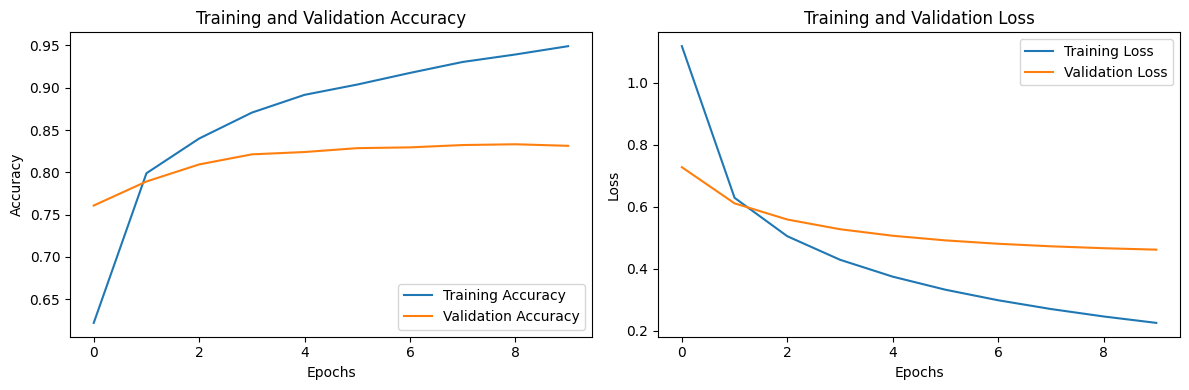


--- Evaluating on Test Data ---
35/35 [==============================] - 4s 97ms/step - loss: 0.5048 - accuracy: 0.8168
Test Loss: 0.5048
Test Accuracy: 0.8168

--- Generating Classification Report and Confusion Matrix ---
35/35 [==============================] - 4s 84ms/step

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.82      0.81      0.82       123
      Food Organics       0.91      0.97      0.94        70
              Glass       0.88      0.75      0.81       139
              Metal       0.79      0.90      0.84       164
Miscellaneous Trash       0.69      0.61      0.65       112
              Paper       0.83      0.84      0.84       166
            Plastic       0.76      0.81      0.79       195
      Textile Trash       0.81      0.78      0.79        54
         Vegetation       0.97      0.94      0.96        69

           accuracy                           0.82      1092
          macro avg      

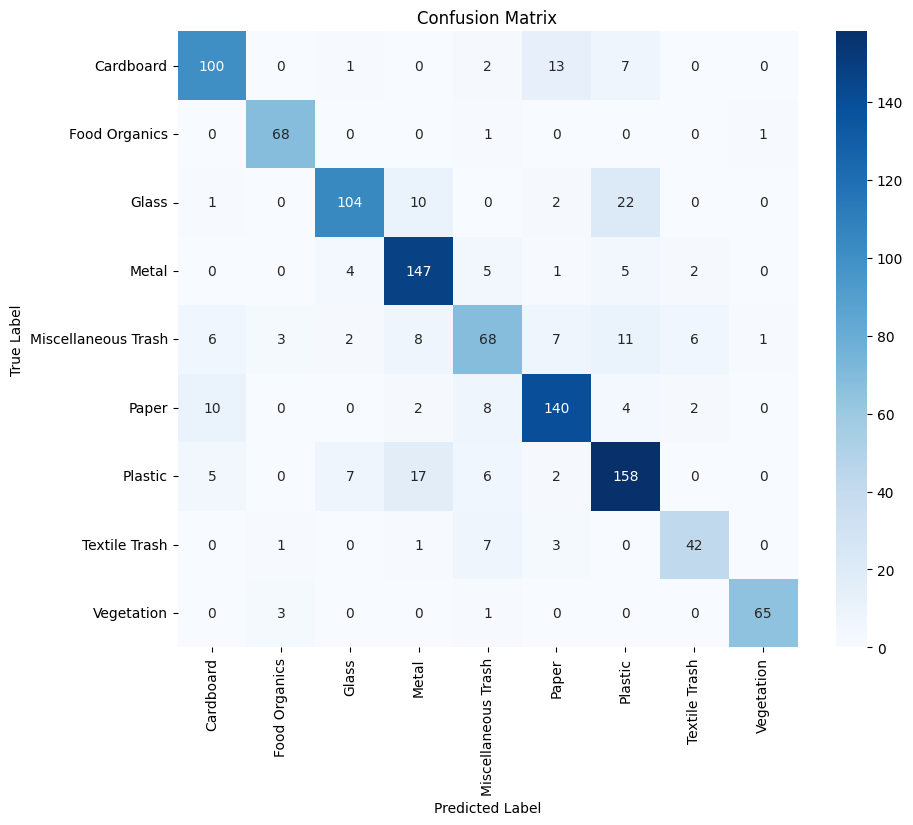

In [10]:
# --- Plotting Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) # Use actual number of epochs run

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# --- Evaluate on Test Set ---
print("\n--- Evaluating on Test Data ---")
# Load the best saved model (if EarlyStopping restored best weights, this might not be strictly necessary
# but good practice if you want to ensure you're using the absolute best checkpoint)
# model = tf.keras.models.load_model("trash_classifier_best_model.keras") # Uncomment if needed

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- Confusion Matrix and Classification Report ---
print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions
y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true_labels = []
for images, labels_batch in test_ds: # Iterate over test_ds to get all true labels
    y_true_labels.extend(np.argmax(labels_batch.numpy(), axis=1))
y_true_labels = np.array(y_true_labels)


# Ensure we have the same number of predictions and true labels
# This can happen if test_ds size is not perfectly divisible by BATCH_SIZE and `drop_remainder=False` (default)
# In image_dataset_from_directory, it typically handles this well.
# If lengths mismatch, you might need to adjust how you extract y_true_labels or handle the last batch.
# For example, if y_pred_labels is shorter:
# y_true_labels = y_true_labels[:len(y_pred_labels)]


print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [1]:
# --- Fine-Tuning (Optional) ---
# Unfreeze some layers of the base model
base_model.trainable = True

# How many layers to unfreeze? It's experimental.
# Let's say we unfreeze the top 20 layers.
# Fine-tune from this layer onwards
# for layer in base_model.layers[:-20]: # Keep earlier layers frozen
#    layer.trainable = False
# Or unfreeze the whole base model (can lead to overfitting if not careful)

# Re-compile the model with a very low learning rate for fine-tuning
fine_tune_lr = initial_learning_rate / 10 # e.g., 0.0001 or 0.00001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr), # Very low LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() # See trainable params increase

# Number of epochs for fine-tuning
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs # If you stopped early, adjust EPOCHS to history.epoch[-1] + 1

print("\n--- Starting Fine-Tuning ---")
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] +1, # Start from where previous training ended
    validation_data=val_ds,
    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb] # Reuse or adjust callbacks
)

# --- Re-evaluate after fine-tuning ---
print("\n--- Evaluating after Fine-Tuning ---")
test_loss_ft, test_accuracy_ft = model.evaluate(test_ds)
print(f"Test Loss (Fine-Tuned): {test_loss_ft:.4f}")
print(f"Test Accuracy (Fine-Tuned): {test_accuracy_ft:.4f}")

# You would then plot the combined history and regenerate confusion matrix etc.
# For combined history:
# acc += history_fine_tune.history['accuracy']
# val_acc += history_fine_tune.history['val_accuracy']
# loss += history_fine_tune.history['loss']
# val_loss += history_fine_tune.history['val_loss']
# And plot against `range(total_epochs)`

NameError: name 'base_model' is not defined

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# --- Make sure these are defined or loaded ---
# Example values, use the ones from your training
IMG_HEIGHT = 224
IMG_WIDTH = 224
class_names = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
] # Ensure this matches your trained model's classes in order

# Load your trained model
model_path = "trash_classifier_best_model.keras" # Or whatever you named it
model = tf.keras.models.load_model(model_path)
print(f"Model loaded from {model_path}")

def preprocess_single_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)  # Converts to float32 numpy array, values 0-255
    img_array = tf.expand_dims(img_array, 0)  # Create a batch: (1, height, width, channels)
    # DO NOT call preprocess_input here if it's already in the model
    return img_array

# Example Usage:
new_image_path = 'plasticBottle1.jpg' # <--- CHANGE THIS TO AN ACTUAL IMAGE PATH
if not tf.io.gfile.exists(new_image_path):
    print(f"Error: Image file not found at {new_image_path}")
    print("Please provide a valid path to an image for prediction.")
else:
    preprocessed_img = preprocess_single_image(new_image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(predictions[0]) * 100 # As percentage

    print(f"Predicted class: {predicted_class_name} with confidence: {confidence:.2f}%")

Model loaded from trash_classifier_best_model.keras


2025-05-12 02:26:53.704862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
Predicted class: Plastic with confidence: 98.33%
